In [2]:
%%html
<style>
.container{width:85%}
<style>

In [3]:
import RL_samp
from RL_samp.header import *
from RL_samp.utils import *
from RL_samp.replay_buffer import *
from RL_samp.models import poly_net, val_net
from RL_samp.reconstructors import unet_solver
from RL_samp.policies import DQN
from RL_samp.trainers import DeepQL_trainer #, AC1_ET_trainer
from unet.unet_model_fbr import Unet
from importlib import reload
import matplotlib.pyplot as plt
from matplotlib import colors
import torch.nn.functional as Func

def rolling_mean(x,window):
    window = int(window)

    # Stephen: for large data, the above gets a bit slow, so we can do this:
#   y = np.convolve(x, np.ones(window)/window, mode='valid')
#   return y
    # or https://stackoverflow.com/a/27681394
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[window:] - cumsum[:-window]) / float(window)

## view training history: DDQN

In [ ]:
hist_dir = '/home/ec2-user/SageMaker/RLsamp/output/DQN_doubleQ_True_ba8_bu16_hist_2023-04-10_BA8BU16_LF_0G_600Epochs.pt'
data = torch.load(hist_dir)
print(data.keys())

In [ ]:
## Loss Convergence Plot
plt.rcParams['text.usetex'] = True
plt.clf()
plt.figure()
window_small = 400
num_ticks = 6
epochs = 600
sequence_length = len(rolling_mean(data['training_record']['rmse'],window_small))

plt.plot(rolling_mean(data['training_record']['rmse'],window_small), linewidth=0.8, label='DDQN')
plt.plot(rolling_mean(data['training_record']['rmse_rand'],window_small), linestyle=':', linewidth=.5,  label='rand.')
plt.plot(rolling_mean(data['training_record']['rmse_lowfreq'],window_small), linestyle='--', linewidth=.5,  label='lowfreq.')
plt.xticks(ticks=np.arange(0, sequence_length, sequence_length//num_ticks), labels=[epochs//num_ticks * i for i in range(0,num_ticks+1)],fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel(r'Normalized $\ell_2$ error', fontsize=20)
plt.legend(loc='best',fontsize=13)
# figname = './figures/DDQN_RMSE_convergence_plot.pdf'
# plt.savefig(figname, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
## make mask convergence plots
sampdim = 144
TOTAL_PTS = 700

T  = len(data['training_record']['recon_samples'])
t0 = 0
t1 = 0

Ts1 = np.arange(t0,t1,1) 
Ts2 = np.linspace(t1, T-1, TOTAL_PTS - (t1-t0)).astype(int)
Ts  = list(Ts1) + list(Ts2)
series = [data['training_record']['recon_samples'][t] for t in Ts]
masks = [item[2] for item in series]
mask_mat = torch.zeros(sampdim,len(Ts))
for ind in range(len(Ts)):
    mask_mat[:,ind] = F.fftshift(masks[ind])

In [ ]:
plt.clf()
plt.figure(figsize=(20,3))
label_fontsize = 20
plt.imshow(mask_mat,origin='lower',cmap='Greys')
# plt.xlabel('time',fontsize=label_fontsize)
# plt.ylabel('frequencies',fontsize=label_fontsize)
plt.yticks([],[])

if t1 > t0:
    plt.xticks([len(Ts1)],[r'$t_\ast$'],fontsize=15)
else:
    plt.xticks([],[])
    
figname = '/home/ec2-user/SageMaker/RLsamp/figures/DDQN_mask.pdf'
plt.savefig(figname, bbox_inches='tight', 
               transparent=True)
plt.show()

In [ ]:
# hist_dir = '/home/ec2-user/SageMaker/RLsamp/output/EVAL_DQN_doubleQ_True_ba8_bu16_2023-05-02.pt'
hist_dir = '/home/ec2-user/SageMaker/RLsamp/output/EVAL_DQN_doubleQ_True_ba8_bu16_2023-05-08.pt'
data = torch.load(hist_dir)
print(data.keys())
print(data['testing_record'].keys())

In [ ]:
T = 22

series = data['testing_record']['recon_samples'][0:T]
gts    = [item[0].squeeze().cpu() for item in series]
recons = [item[1].squeeze().cpu() for item in series]

figsize = (10,40)
nrows = 6
ncols = 3
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)

window_large = 300
window_small = 300

frame = np.linspace(0,T-1,nrows).astype(int)
for i in range(nrows):
    axs[i,0].imshow(gts[frame[i]],vmin=0,vmax=1,cmap='gray')
    axs[i,1].set_title(fr'$t={frame[i]+1}$')
    axs[i,1].imshow(recons[frame[i]],vmin=0,vmax=1,cmap='gray')
    hdl = axs[i,2].imshow(abs(recons[frame[i]]-gts[frame[i]])/gts[frame[i]] , norm=colors.LogNorm(vmin=0.1,vmax=10), cmap='winter')
    fig.colorbar(hdl, ax=axs[i,2], location='right', anchor=(0, 0.5), shrink=0.5)

for i in range(nrows):
    for j in range(ncols):
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        
plt.subplots_adjust(wspace=.1, hspace=0)
plt.show()

In [ ]:
figsize = (15,15)
fig, axs = plt.subplots(nrows=3,ncols=3,figsize=figsize)

window_large = 300
window_small = 300

axs[0,0].plot(rolling_mean(data['training_record']['poly_loss'], window_large))
axs[0,0].set_title('policy network running loss')

axs[0,1].plot(rolling_mean(data['training_record']['val_loss'],window_small))
axs[0,1].set_title('Value network running loss')
# axs[0,2].set_yscale('log')

axs[0,2].plot(rolling_mean(data['training_record']['v'],window_small))
axs[0,2].set_title('running v value')

axs[1,0].plot(rolling_mean(data['training_record']['horizon_rewards'],window_large))
axs[1,0].set_title('Horizon Rewards')


axs[1,1].plot(rolling_mean(data['training_record']['poly_grad_norm'],window_large))
axs[1,1].set_title('polynet Grad Norm')
# axs[1,1].set_yscale('log')

axs[1,2].plot(rolling_mean(data['training_record']['val_grad_norm'],window_large))
axs[1,2].set_title('valnet Grad Norm')
axs[1,2].set_yscale('log')

axs[2,0].plot(rolling_mean(data['training_record']['rmse'],window_small), label='RL')
axs[2,0].plot(rolling_mean(data['training_record']['rmse_rand'],window_small), label='rand')
axs[2,0].plot(rolling_mean(data['training_record']['rmse_lowfreq'],window_small), label='lowfreq.')
axs[2,0].set_title('RMSE - recon')
axs[2,0].legend(loc='best')
# axs[0,1].set_yscale('log')

gt = axs[2,1].imshow(data['training_record']['recon_samples'][-1][0][0,0,:,:])
axs[2,1].set_title('Recon')
fig.colorbar(gt, ax=axs[2,1], location='right', anchor=(0, 0.3), shrink=0.7)

recon = axs[2,2].imshow(data['training_record']['recon_samples'][-1][1][0,0,:,:])
axs[2,2].set_title('Target gt')
fig.colorbar(recon, ax=axs[2,2], location='right', anchor=(0, 0.3), shrink=0.7)


plt.show()

## view training history: REINFORCE

In [8]:
## view training history: REINFORCE
# hist_dir = '/home/ec2-user/SageMaker/RLsamp/output/REINFORCE_hist_2023-04-24_base8_budget16_BA8_BU16_E1000_G0_H1e-2_wTrue_magweg5_rwd1.pt'
# hist_dir = '/home/ec2-user/SageMaker/RLsamp/output/Test_REINFORCE_hist_2023-05-02_base8_budget16_REINFORCE_test_magweg1.0_rwd1.pt'
hist_dir = '/home/ec2-user/SageMaker/RLsamp/output/Test_REINFORCE_hist_2023-05-08_base8_budget16_REINFORCE_test_magweg1.0_rwd1.pt'
# hist_dir = '/home/ec2-user/SageMaker/RLsamp/output/Test_REINFORCE_hist_2023-05-29_base8_budget16_REINFORCE_test_magweg1.0_rwd1.pt'

data = torch.load(hist_dir)
print(data.keys())
print(data['testing_record'].keys())

dict_keys(['testing_record'])
dict_keys(['rmse', 'recon_samples', 'rmse_rand', 'rmse_lowfreq', 'ssim', 'ssim_rand', 'ssim_lowfreq'])


<Figure size 640x480 with 0 Axes>

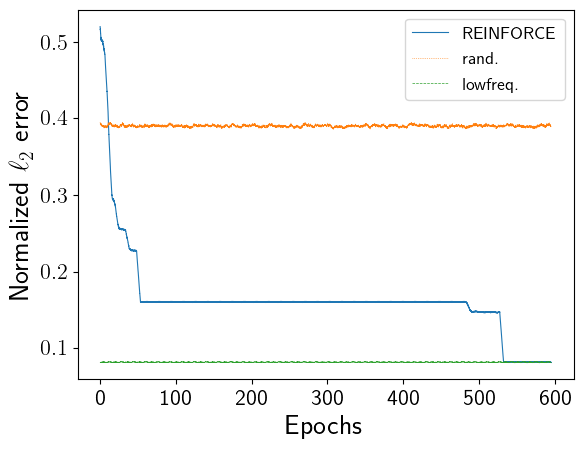

In [5]:
## Loss Convergence Plot
plt.rcParams['text.usetex'] = True
plt.clf()
plt.figure()
window_small = 400
num_ticks = 6

epochs_total = 1000
epochs = 600
sequence_length = len(rolling_mean(data['training_record']['rmse'],window_small))
plot_range = epochs * sequence_length//epochs_total

plt.plot(rolling_mean(data['training_record']['rmse'][:plot_range],window_small), linewidth=0.8, label='REINFORCE')
plt.plot(rolling_mean(data['training_record']['rmse_rand'][:plot_range],window_small), linestyle=':', linewidth=.5,  label='rand.')
plt.plot(rolling_mean(data['training_record']['rmse_lowfreq'][:plot_range],window_small), linestyle='--', linewidth=.5,  label='lowfreq.')
plt.xticks(ticks=np.arange(0, plot_range, plot_range//num_ticks), labels=[epochs//num_ticks * i for i in range(0,num_ticks+1)],fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel(r'Normalized $\ell_2$ error', fontsize=20)
plt.legend(loc='best',fontsize=13)
figname = './figures/REINFORCE_RMSE_convergence_plot.pdf'
plt.savefig(figname, bbox_inches='tight', 
               transparent=True)
plt.show()

In [6]:
## make mask convergence plots
sampdim = 144
TOTAL_PTS = 700

T  = len(data['training_record']['recon_samples'])
t0 = 0
t1 = 0

Ts1 = np.arange(t0,t1,1) 
Ts2 = np.linspace(t1, T-1, TOTAL_PTS - (t1-t0)).astype(int)
Ts  = list(Ts1) + list(Ts2)
series = [data['training_record']['recon_samples'][t] for t in Ts]
masks = [item[2] for item in series]
mask_mat = torch.zeros(sampdim,len(Ts))
for ind in range(len(Ts)):
    mask_mat[:,ind] = F.fftshift(masks[ind])

<Figure size 640x480 with 0 Axes>

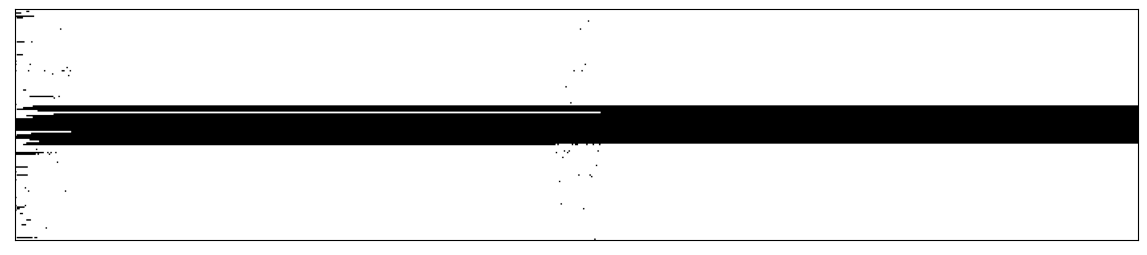

In [7]:
plt.clf()
plt.figure(figsize=(20,3))
label_fontsize = 20
plt.imshow(mask_mat,origin='lower',cmap='Greys')
# plt.xlabel('time',fontsize=label_fontsize)
# plt.ylabel('frequencies',fontsize=label_fontsize)
plt.yticks([],[])

if t1 > t0:
    plt.xticks([len(Ts1)],[r'$t_\ast$'],fontsize=15)
else:
    plt.xticks([],[])
    
figname = '/home/ec2-user/SageMaker/RLsamp/figures/REINFORCE_mask.pdf'
plt.savefig(figname, bbox_inches='tight', 
               transparent=True)
plt.show()

In [5]:
# dataloader params
t_backtrack = 8
datapath = '/home/ec2-user/SageMaker/data/OCMR_fully_sampled_images/'

# unet params
unet_rand_dir = '/home/ec2-user/SageMaker/RLsamp/output/recon_models/unet_lowfreq_rand_1.0_fbr_2_chans_64base8_budget16.pt'
unet_lowfreq_dir = '/home/ec2-user/SageMaker/RLsamp/output/recon_models/unet_lowfreq_rand_0.0_fbr_2_chans_64base8_budget16.pt'
unet_prob_dir = '/home/ec2-user/SageMaker/RLsamp/output/recon_models/unet_prob_rand_0.0_fbr_2_chans_64base8_budget16.pt'

probdistr_dir = '/home/ec2-user/SageMaker/RLsamp/output/probdist_train_base_8.pt'

in_chans = 2
chans = 64
num_pool_layers = 6

# tester params
fulldim = 144
base    = 8
budget  = 16
device  = torch.device("cuda:1")

In [6]:
unet_rand = Unet(in_chans=in_chans,out_chans=1,chans=chans,
            num_pool_layers=num_pool_layers,drop_prob=0).to(device)
rand_checkpoint = torch.load(unet_rand_dir)
unet_rand.load_state_dict(rand_checkpoint['model_state_dict'])

unet_lowfreq = Unet(in_chans=in_chans,out_chans=1,chans=chans,
            num_pool_layers=num_pool_layers,drop_prob=0).to(device)
lowfreq_checkpoint = torch.load(unet_lowfreq_dir)
unet_lowfreq.load_state_dict(lowfreq_checkpoint['model_state_dict'])

unet_lowfreq = Unet(in_chans=in_chans,out_chans=1,chans=chans,
            num_pool_layers=num_pool_layers,drop_prob=0).to(device)
lowfreq_checkpoint = torch.load(unet_lowfreq_dir)
unet_lowfreq.load_state_dict(lowfreq_checkpoint['model_state_dict'])

unet_prob = Unet(in_chans=in_chans,out_chans=1,chans=chans,
            num_pool_layers=num_pool_layers,drop_prob=0).to(device)
prob_checkpoint = torch.load(unet_prob_dir)
unet_prob.load_state_dict(lowfreq_checkpoint['model_state_dict'])

probdistr = torch.load(probdistr_dir)[f'probability_density_base_{base}']

In [9]:
T = 16

series = data['testing_record']['recon_samples'][0:T]
recons = [item[0].squeeze().cpu() for item in series]
gts    = [item[1].squeeze().cpu() for item in series]

In [10]:
def mask_given_prob(sampdim,probdistr,fix=8,other=16,roll=False):
    '''
    input imgs: [NCHW]
    '''
    fix   = int(fix)
    other = int(other)

    fixInds  = np.concatenate((np.arange(0,round(fix//2) ),np.arange(sampdim-1,sampdim-1-round(fix/2),-1)))
    addInds  = np.random.choice(np.arange(sampdim),size=other,replace=False,p=probdistr.numpy())
    maskInds = np.concatenate((fixInds,addInds))
    mask     = np.zeros(sampdim)
    mask[maskInds]= 1
    if roll:
        mask = np.roll(mask,shift=sampdim//2,axis=0)
    return mask

In [11]:
# make recons for Rand, lowfreq, prob.
recons_rand = []
recons_lowfreq = []
recons_prob = []

mask_lowfreq = mask_naiveRand(fulldim,fix=base+budget,other=budget,roll=False) 
with torch.no_grad():
    for img_gt in gts:
        img_gt = img_gt.unsqueeze(0).unsqueeze(0)

        mask_rand = mask_naiveRand(fulldim,fix=base,other=budget,roll=False) 
        target_obs_rand = fft_observe(img_gt,mask_rand,return_opt='img', abs_opt=False)
        recon_rand   = unet_solver(target_obs_rand.to(device), unet_rand)
        recons_rand.append(torch.squeeze(recon_rand).cpu())

        target_obs_lowfreq = fft_observe(img_gt,mask_lowfreq,return_opt='img', abs_opt=False)
        recon_lowfreq = unet_solver(target_obs_lowfreq.to(device), unet_lowfreq)
        recons_lowfreq.append(torch.squeeze(recon_lowfreq).cpu())

        mask_prob = mask_given_prob(sampdim=fulldim,probdistr=probdistr,fix=base,other=budget)
        target_obs_prob = fft_observe(img_gt,mask_prob,return_opt='img', abs_opt=False)
        recon_prob = unet_solver(target_obs_prob.to(device), unet_prob)
        recons_prob.append(torch.squeeze(recon_prob).cpu())

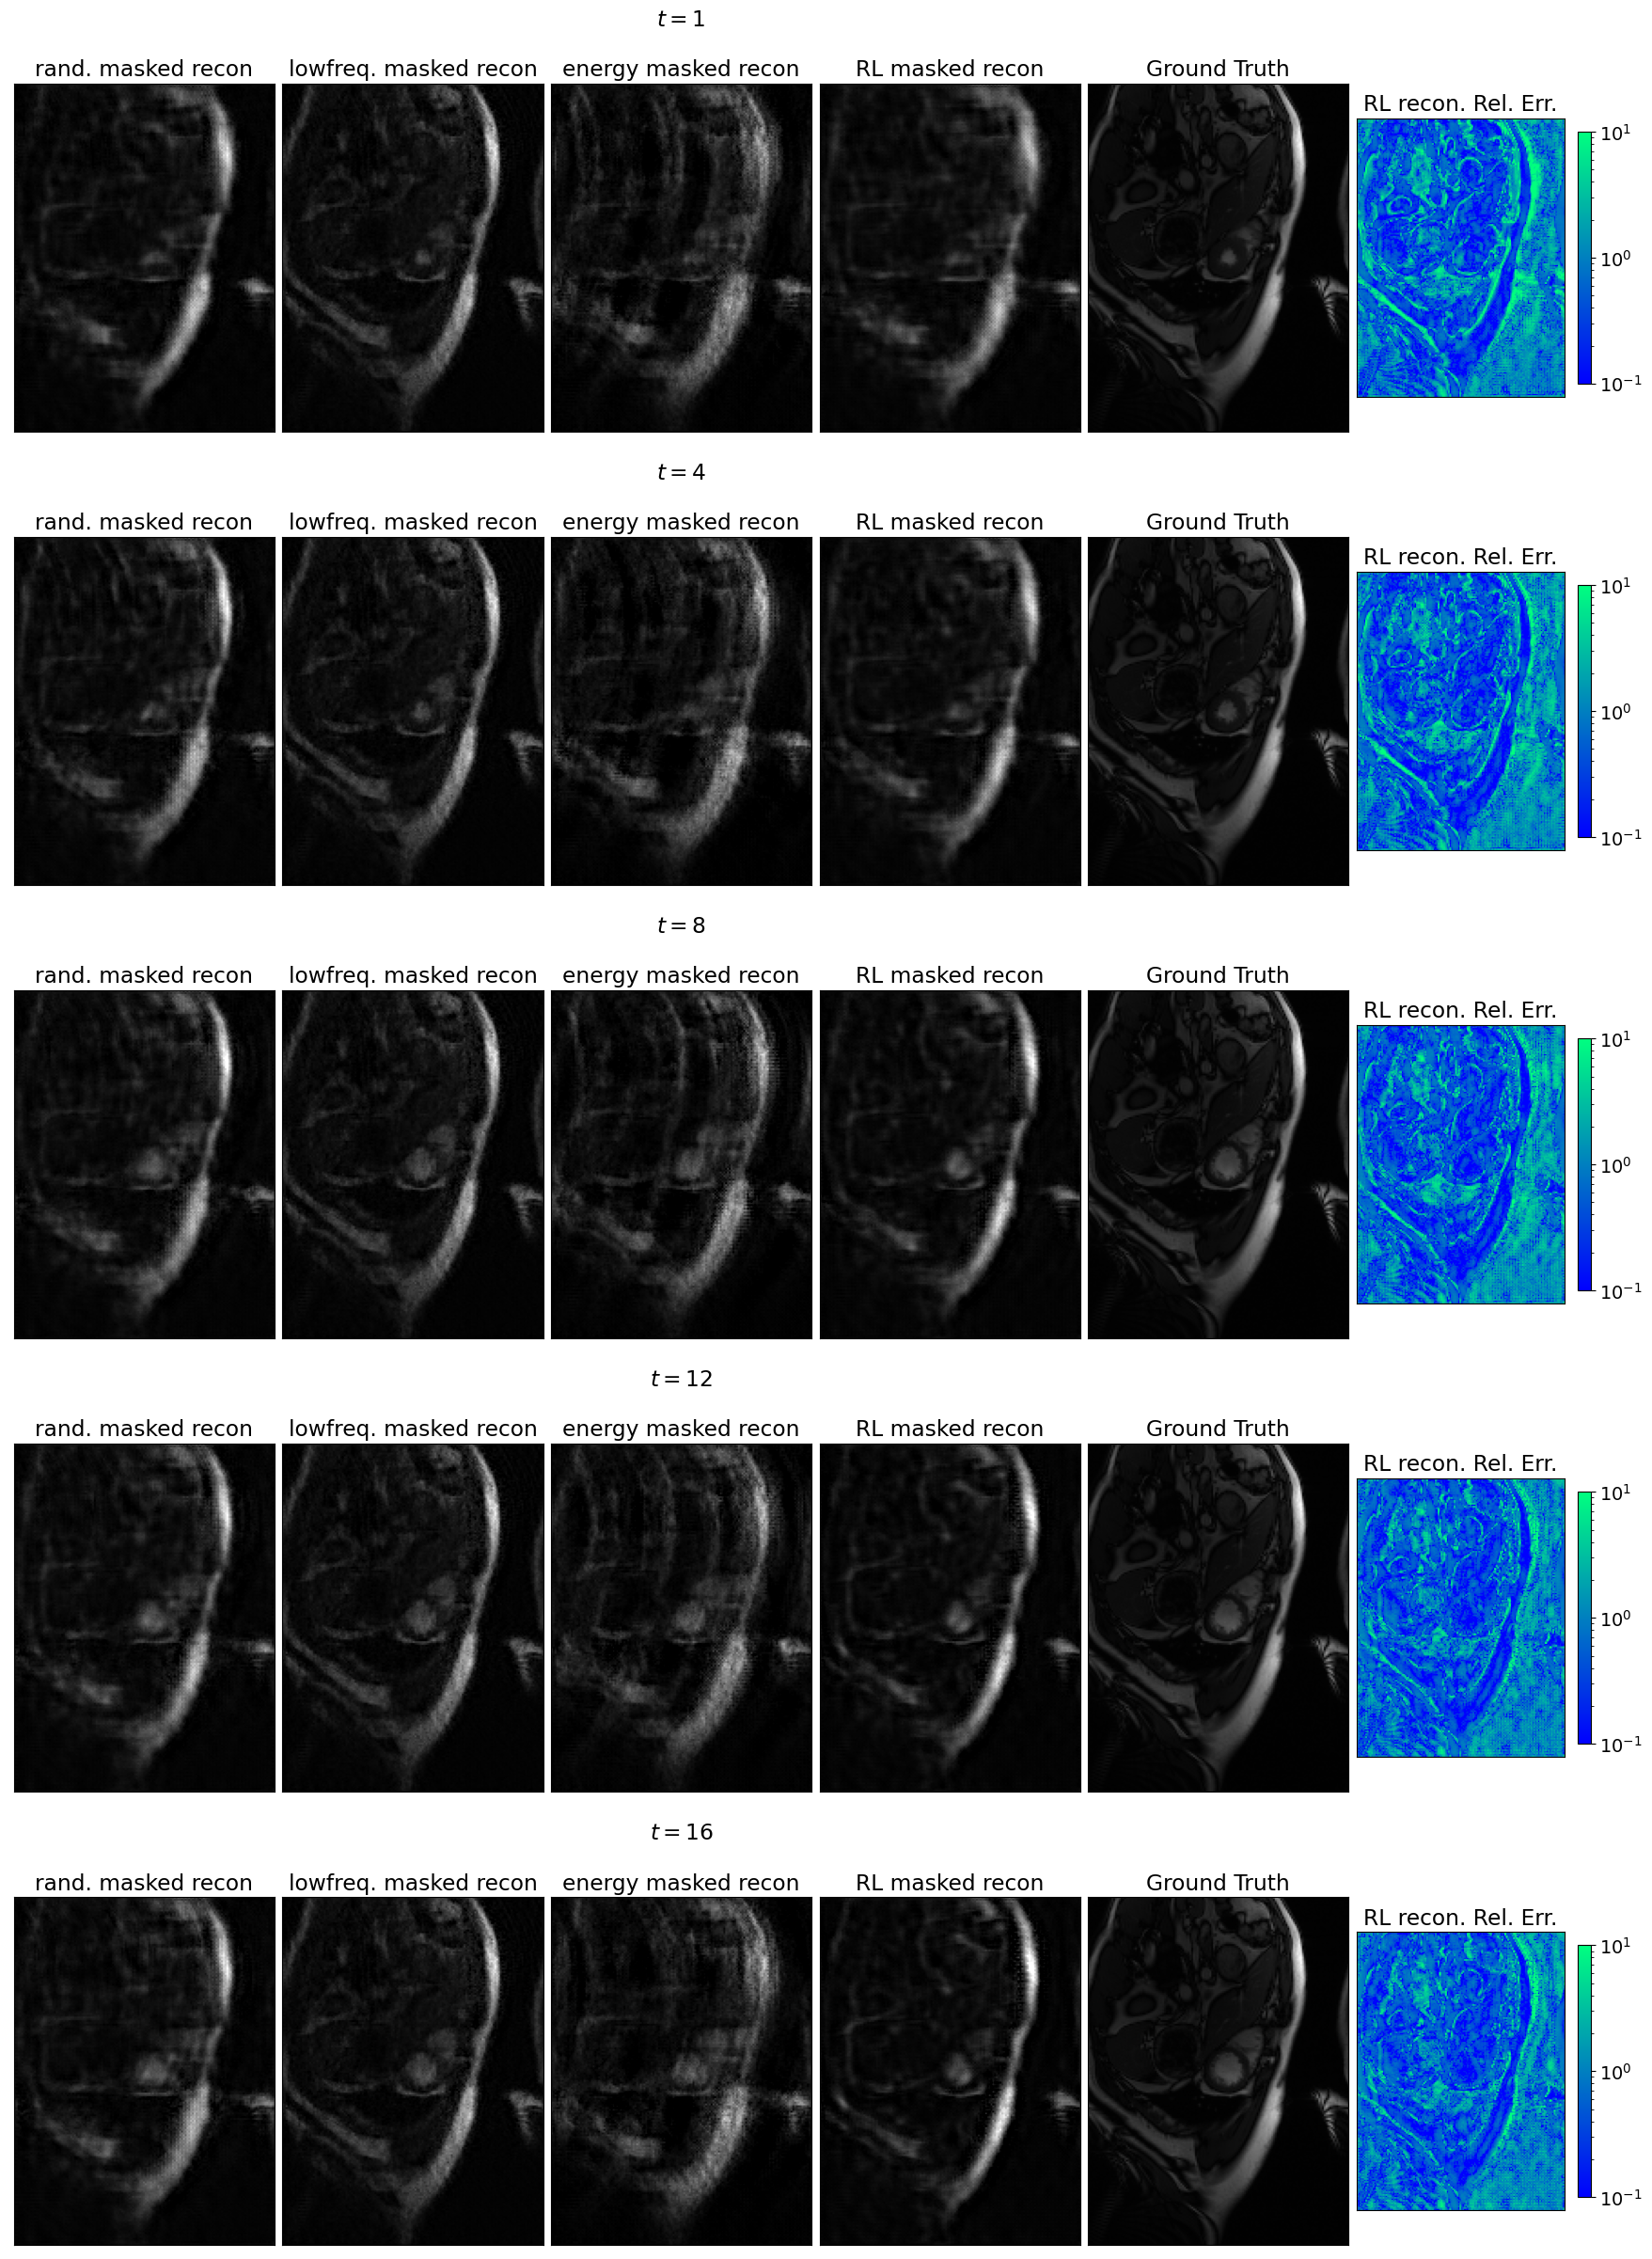

In [18]:
figsize = (22,32)
nrows = 5
ncols = 6
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
plt.rcParams.update({'font.size': 14})
window_large = 300
window_small = 300

new_line = '\n'

frame = np.linspace(0,T-1,nrows).astype(int)
for i in range(nrows):
    axs[i,0].imshow(recons_rand[frame[i]],vmin=0,vmax=1,cmap='gray')
    axs[i,0].set_title(fr'rand. masked recon')
    axs[i,1].imshow(recons_lowfreq[frame[i]],vmin=0,vmax=1,cmap='gray')
    axs[i,1].set_title(fr'lowfreq. masked recon')
    axs[i,2].imshow(recons_prob[frame[i]],vmin=0,vmax=1,cmap='gray')
    axs[i,2].set_title(fr'$t={frame[i]+1}${new_line}{new_line}energy masked recon')
    axs[i,3].imshow(recons[frame[i]],vmin=0,vmax=1,cmap='gray')
    axs[i,3].set_title(fr'RL masked recon')
    axs[i,4].imshow(gts[frame[i]],vmin=0,vmax=1,cmap='gray')
    axs[i,4].set_title(fr'Ground Truth')
    hdl = axs[i,5].imshow(abs(recons[frame[i]]-gts[frame[i]])/gts[frame[i]] , norm=colors.LogNorm(vmin=0.1,vmax=10), cmap='winter')
    axs[i,5].set_title(fr'RL recon. Rel. Err.')
    fig.colorbar(hdl, ax=axs[i,5], location='right', anchor=(0, 0.5), shrink=0.5)

for i in range(nrows):
    for j in range(ncols):
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
plt.subplots_adjust(wspace=.03, hspace=-0.1)
figname = '/home/ec2-user/SageMaker/RLsamp/figures/REINFORCE_recon_example_May29.pdf'
plt.savefig(figname, bbox_inches='tight', transparent=True)
plt.show()

KeyError: 'training_record'

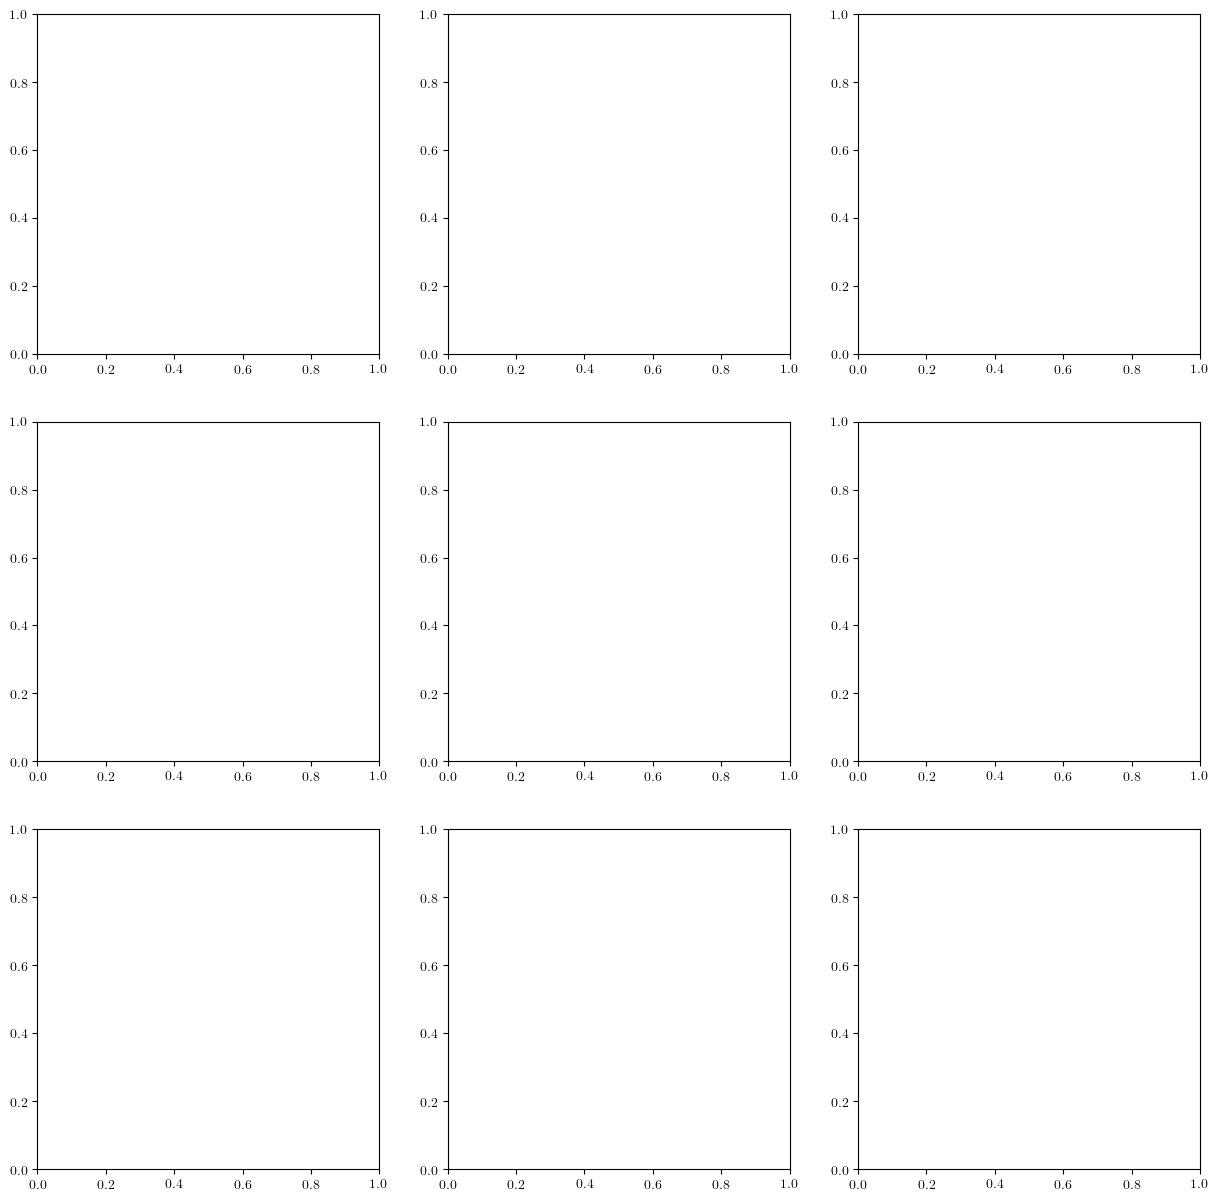

In [17]:
figsize = (15,15)
fig, axs = plt.subplots(nrows=3,ncols=3,figsize=figsize)

window_large = 300
window_small = 300

axs[0,0].plot(rolling_mean(data['training_record']['poly_loss'], window_large))
axs[0,0].set_title('policy network running loss')

axs[0,1].plot(rolling_mean(data['training_record']['poly_grad_norm'],window_small))
axs[0,1].set_title('policy network gradient norm')
axs[0,2].set_yscale('log')

axs[0,2].plot(rolling_mean(data['training_record']['action_prob'],window_small))
axs[0,2].set_title('action probability')

axs[1,0].plot(rolling_mean(data['training_record']['horizon_rewards'],window_large))
axs[1,0].set_title('Horizon Rewards')


# axs[1,1].plot(rolling_mean(data['training_record']['poly_grad_norm'],window_large))
# axs[1,1].set_title('polynet Grad Norm')
# # axs[1,1].set_yscale('log')

# axs[1,2].plot(rolling_mean(data['training_record']['val_grad_norm'],window_large))
# axs[1,2].set_title('valnet Grad Norm')
# axs[1,2].set_yscale('log')

axs[1,1].plot(rolling_mean(data['training_record']['rmse'],window_small), label='RL')
axs[1,1].plot(rolling_mean(data['training_record']['rmse_rand'],window_small), label='rand')
axs[1,1].plot(rolling_mean(data['training_record']['rmse_lowfreq'],window_small), label='lowfreq.')
axs[1,1].set_title('RMSE - recon')
axs[1,1].legend(loc='best')
# axs[0,1].set_yscale('log')

axs[1,2].axis('off')

gt = axs[2,0].imshow(data['training_record']['recon_samples'][-1][0][0,0,:,:], origin='lower')
axs[2,0].set_title('Target gt')
fig.colorbar(gt, ax=axs[2,0], location='right', anchor=(0, 0.3), shrink=0.7)

recon = axs[2,1].imshow(data['training_record']['recon_samples'][-1][1][0,0,:,:], origin='lower')
axs[2,1].set_title('Recon')
fig.colorbar(recon, ax=axs[2,1], location='right', anchor=(0, 0.3), shrink=0.7)

rel_error = axs[2,2].imshow((data['training_record']['recon_samples'][-1][1][0,0,:,:] - data['training_record']['recon_samples'][-1][0][0,0,:,:])/data['training_record']['recon_samples'][-1][0][0,0,:,:],
                            origin='lower', norm=colors.LogNorm())
axs[2,2].set_title('Relative Error')
fig.colorbar(rel_error, ax=axs[2,2], location='right', anchor=(0, 0.3), shrink=0.7)

plt.show()